In [104]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler
import itertools
import copy

In [105]:
# Set the random seed for reproducibility
# This ensures that the results of the code are the same every time it is run
# This is important for debugging and for comparing the results of different experiments
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [106]:
# This cell reads data from a CSV file, preprocesses it, and calculates basic statistics.
# It loads the data, handles missing values, calculates 'Movement', 'Return', and 'Range', and prints summary statistics.
df = pd.read_csv('../data/newset/combined_sentiment_stock_AAPL.csv')
df = df.dropna(subset=['Open', 'Close']).copy().reset_index(drop=True)
df['Movement'] = (df['Close'] > df['Open']).astype(int)
df['Return'] = (df['Close'] - df['Open']) / df['Open']
df['Range'] = (df['High'] - df['Low']) / df['Open']
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(subset=['Return', 'Range'], inplace=True)

# Display basic statistics
up_days = df['Movement'].sum()
down_days = len(df) - up_days
print(f"Total samples after cleaning: {len(df)}")
print(f"Up days: {up_days}, Down days: {down_days} (Up {up_days/len(df):.1%}, Down {down_days/len(df):.1%})")


Total samples after cleaning: 83
Up days: 50, Down days: 33 (Up 60.2%, Down 39.8%)


In [107]:
# This cell defines the features to be used for the model and extracts them from the DataFrame.
# It also extracts the target variable ('Movement') and converts both to numpy arrays.
features = ['posts_per_day', 'avg_sentiment', 'Return', 'Range', 'Volume']
has_date_col = 'date_only_stock' in df.columns
features = [f for f in features if f in df.columns]
if not features:
    raise ValueError("No valid features selected or found in the DataFrame.")

X_all = df[features].astype(float).values
y_all = df['Movement'].values

In [108]:
seq_length = 5
total_data_points = len(df)
total_sequences = len(df) - seq_length
if total_sequences <= 0:
    raise ValueError(f"Data length ({len(df)}) is less than or equal to sequence length ({seq_length}). Cannot create sequences.")

# Calculate split counts
train_seq_count = int(0.6 * total_sequences)
val_seq_count = int(0.2 * total_sequences)
test_seq_count = total_sequences - train_seq_count - val_seq_count

# Handle small dataset case
if train_seq_count < 1 or val_seq_count < 1 or test_seq_count < 1:
    # If the initial split results in any set having less than 1 sequence,
    # try to adjust the split to ensure each set has at least 1 sequence.
    if total_sequences >= 3:
        train_seq_count = max(1, int(total_sequences * 0.6))
        val_seq_count = max(1, int(total_sequences * 0.2))
        test_seq_count = max(1, total_sequences - train_seq_count - val_seq_count)
        if test_seq_count < 1:
            # If test set still has less than 1 sequence, redistribute sequences
            train_seq_count = int(total_sequences / 3)
            val_seq_count = int(total_sequences / 3)
            test_seq_count = total_sequences - train_seq_count - val_seq_count
            train_seq_count = max(1, train_seq_count)
            val_seq_count = max(1, val_seq_count)
            test_seq_count = max(1, test_seq_count)
    if train_seq_count < 1 or val_seq_count < 1 or test_seq_count < 1:
        # If even after adjustment, some sets still have less than 1 sequence,
        # raise an error indicating that the dataset is too small for the given sequence length.
        raise ValueError(f"Not enough data to create train ({train_seq_count}), val ({val_seq_count}), and test ({test_seq_count}) sets with seq_length={seq_length}. Total sequences: {total_sequences}")


In [109]:
# This cell prepares the data for the LSTM model by scaling the features and creating sequences.
# It first calculates the indices to split the data into training, validation, and test sets.
# Then, it scales the features using StandardScaler, fitted only on the training data to prevent data leakage.
# Finally, it creates sequences of features and corresponding labels for the LSTM model.

train_data_end_idx_original = seq_length + train_seq_count - 1
val_data_end_idx_original = seq_length + train_seq_count + val_seq_count - 1

print(f"Train original indices up to: {train_data_end_idx_original}")
print(f"Val original indices up to: {val_data_end_idx_original}")

# Scale features based on training data only
scaler = StandardScaler()
scaler.fit(X_all[:train_data_end_idx_original + 1, :])
X_all_scaled = scaler.transform(X_all)

# Create sequences
X_sequences = []
y_sequences = []
for i in range(seq_length, len(df)):
    X_sequences.append(X_all_scaled[i-seq_length:i, :])
    y_sequences.append(y_all[i])

X_sequences = np.array(X_sequences)
y_sequences = np.array(y_sequences)

Train original indices up to: 50
Val original indices up to: 65


In [110]:
# Check if the actual number of created sequences (X_sequences) matches the expected total; if not, recalculate split counts.
# Adjust the train/validation/test counts to ensure each set has at least one sequence (with at least 3 sequences overall).
# Print the final sequence shapes and split the sequences into train, validation, and test sets accordingly.
if len(X_sequences) != total_sequences:
    print(f"Warning: Created {len(X_sequences)} sequences, but expected {total_sequences}. Recalculating counts.")
    total_sequences = len(X_sequences)
    train_seq_count = int(0.6 * total_sequences)
    val_seq_count = int(0.2 * total_sequences)
    test_seq_count = total_sequences - train_seq_count - val_seq_count

    if train_seq_count < 1 or val_seq_count < 1 or test_seq_count < 1:
        if total_sequences >= 3:
            train_seq_count = max(1, int(total_sequences / 3))
            val_seq_count = max(1, int(total_sequences / 3))
            test_seq_count = total_sequences - train_seq_count - val_seq_count
            if test_seq_count < 1:
                train_seq_count = int(total_sequences / 3)
                val_seq_count = int(total_sequences / 3)
                test_seq_count = total_sequences - train_seq_count - val_seq_count
                train_seq_count = max(1, train_seq_count)
                val_seq_count = max(1, val_seq_count)
                test_seq_count = max(1, test_seq_count)
        if train_seq_count < 1 or val_seq_count < 1 or test_seq_count < 1:
            raise ValueError(f"Still not enough sequences after adjustment. Train:{train_seq_count}, Val:{val_seq_count}, Test:{test_seq_count}. Total sequences: {total_sequences}")

print(f"Sequence shape: {X_sequences.shape}")
print(f"Train sequences: {train_seq_count}, Val sequences: {val_seq_count}, Test sequences: {test_seq_count}")

# Split the complete sequences and corresponding labels into training, validation, and test sets
X_train = X_sequences[:train_seq_count]
y_train = y_sequences[:train_seq_count]
X_val = X_sequences[train_seq_count:train_seq_count + val_seq_count]
y_val = y_sequences[train_seq_count:train_seq_count + val_seq_count]
X_test = X_sequences[train_seq_count + val_seq_count:]
y_test = y_sequences[train_seq_count + val_seq_count:]

print(f"Train seqs: {X_train.shape[0]}, Val seqs: {X_val.shape[0]}, Test seqs: {X_test.shape[0]}")

Sequence shape: (78, 5, 5)
Train sequences: 46, Val sequences: 15, Test sequences: 17
Train seqs: 46, Val seqs: 15, Test seqs: 17


In [111]:
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)
X_val_t = torch.tensor(X_val, dtype=torch.float32)
y_val_t = torch.tensor(y_val, dtype=torch.float32)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32)


In [112]:
train_up_count = y_train_t.sum().item()
train_down_count = len(y_train_t) - train_up_count

print(f"Train sequence label distribution: Up={int(train_up_count)}, Down={int(train_down_count)}")

# Calculate positive weight for loss function
pos_weight_value = train_down_count / train_up_count if train_up_count > 0 else 1.0
print(f"Calculated pos_weight: {pos_weight_value:.2f}")
pos_weight_tensor = torch.tensor(pos_weight_value, dtype=torch.float32)

# Setup weighted sampler if we have both classes
if train_up_count > 0 and train_down_count > 0:
    class_sample_counts = np.array([train_down_count, train_up_count])
    weight = 1. / class_sample_counts
    samples_weight = np.array([weight[int(t)] for t in y_train_t])
    samples_weight = torch.from_numpy(samples_weight).double()
    sampler = WeightedRandomSampler(samples_weight, len(samples_weight))
    print("Using WeightedRandomSampler.")
else:
    sampler = None
    print("Skipping WeightedRandomSampler due to single class in training data.")

Train sequence label distribution: Up=31, Down=15
Calculated pos_weight: 0.48
Using WeightedRandomSampler.


In [113]:
train_dataset = TensorDataset(X_train_t, y_train_t)
base_batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=base_batch_size, sampler=sampler if sampler else None, shuffle=sampler is None, drop_last=False)

val_dataset = TensorDataset(X_val_t, y_val_t)
val_loader = DataLoader(val_dataset, batch_size=base_batch_size, shuffle=False, drop_last=False)

In [114]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout_rate):
        super(LSTMClassifier, self).__init__()
        # Save model hyperparameters
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # Use dropout only if there is more than one LSTM layer
        lstm_dropout = dropout_rate if num_layers > 1 else 0
        
        # Define LSTM layer
        # batch_first=True means the input shape is (batch, seq, feature)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers,
                            batch_first=True, dropout=lstm_dropout)
        # Dropout layer applied after LSTM output
        self.dropout = nn.Dropout(dropout_rate)
        # Fully connected layer to convert LSTM output to a single logit for binary classification
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        # Pass input through LSTM; we ignore the hidden state
        lstm_out, _ = self.lstm(x)
        # Extract the output of the last time step
        last_out = lstm_out[:, -1, :]
        # Apply dropout regularization
        dropped_out = self.dropout(last_out)
        # Produce the final logit value
        logit = self.fc(dropped_out)
        # Remove extra dimensions if present
        return logit.squeeze(1)

In [115]:
# Define the input dimension for the LSTM model based on the number of features in the training data
input_dim = X_train.shape[2]

# Define a grid of hyperparameters for the grid search
param_grid = {
    'hidden_dim': [16, 32, 64],  # Number of hidden units in the LSTM layers
    'num_layers': [1, 2],        # Number of LSTM layers
    'dropout_rate': [0.3, 0.5],  # Dropout rate to prevent overfitting
    'lr': [0.001, 0.005, 0.01],  # Learning rate for the optimizer
    'weight_decay': [1e-4, 1e-3] # Weight decay (L2 regularization) for the optimizer
}

# Generate all possible combinations of hyperparameters from the grid
all_params = list(itertools.product(*param_grid.values()))

# Print the total number of parameter combinations to be tested
print(f"\n--- Starting Grid Search ---")
print(f"Total parameter combinations to test: {len(all_params)}")


--- Starting Grid Search ---
Total parameter combinations to test: 72


In [116]:
# Set initial best validation loss to infinity and initialize variables to store best parameters, model state, and results
best_val_loss = float('inf')
best_params = None
best_model_state = None
results = []

# Early stopping parameters and maximum epochs
patience = 15   # Number of epochs with no improvement before stopping early
min_delta = 0.001  # Minimum decrease in validation loss to qualify as an improvement
epochs = 100

# Iterate over each combination of hyperparameters from the grid search
for i, param_values in enumerate(all_params):
    # Create a dictionary of current hyperparameters by zipping keys of param_grid with current values
    current_params = dict(zip(param_grid.keys(), param_values))
    print(f"\n--- Run {i+1}/{len(all_params)} ---")
    print(f"Parameters: {current_params}")

    # Separate parameters for model and optimizer creation
    model_specific_params = {
        'hidden_dim': current_params['hidden_dim'],
        'num_layers': current_params['num_layers'],
        'dropout_rate': current_params['dropout_rate']
    }
    optimizer_specific_params = {
        'lr': current_params['lr'],
        'weight_decay': current_params['weight_decay']
    }

    # Initialize the model with the current hyperparameters
    model = LSTMClassifier(input_dim=input_dim, **model_specific_params)

    # Create the loss criterion, here using a weighted binary cross-entropy with logits
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor)

    # Create the optimizer (AdamW) with learning rate and weight decay from current hyperparameters
    optimizer = optim.AdamW(model.parameters(),
                            lr=current_params['lr'],
                            weight_decay=current_params['weight_decay'])

    # Initialize variables to track the best loss within this run and early stopping state
    run_best_val_loss = float('inf')
    run_epochs_no_improve = 0
    run_early_stop = False
    run_best_model_state_for_this_run = None

    # History dictionary to store training and validation losses and accuracies per epoch for this run
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    # Epoch loop for training the model
    for epoch in range(1, epochs + 1):
        if run_early_stop:
            # Exit the epoch loop if no improvement is seen for "patience" epochs
            print(f"Early stopping triggered at epoch {epoch-1} for this run.")
            break

        # Training phase: set model to training mode
        model.train()
        epoch_loss = 0.0
        correct = total_samples = 0
        
        # Process batches from the training data loader
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()                   # Reset gradients
            logits = model(X_batch)                   # Forward pass
            loss = criterion(logits, y_batch)         # Compute loss
            loss.backward()                           # Backpropagation
            optimizer.step()                          # Update model parameters

            # Update cumulative training loss (weighted by batch size)
            epoch_loss += loss.item() * len(X_batch)
            
            # Compute number of correct predictions for accuracy calculation
            preds = (torch.sigmoid(logits) >= 0.5).long()
            correct += (preds == y_batch.long()).sum().item()
            total_samples += len(X_batch)
        train_loss = epoch_loss / total_samples      # Average training loss
        train_acc = correct / total_samples          # Training accuracy

        # Validation phase: set model to evaluation mode
        model.eval()
        val_epoch_loss = 0.0
        val_correct = val_total_samples = 0
        with torch.no_grad():  # Disable gradient calculation for validation
            for X_val_batch, y_val_batch in val_loader:
                val_logits = model(X_val_batch)              # Forward pass on validation batch
                val_batch_loss = criterion(val_logits, y_val_batch)  # Compute validation loss
                val_epoch_loss += val_batch_loss.item() * len(X_val_batch)
                val_preds = (torch.sigmoid(val_logits) >= 0.5).long()  # Convert logits to binary predictions
                val_correct += (val_preds == y_val_batch.long()).sum().item()
                val_total_samples += len(X_val_batch)
        val_loss = val_epoch_loss / val_total_samples   # Average validation loss
        val_acc = val_correct / val_total_samples       # Validation accuracy

        # Record the loss and accuracy for the current epoch
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        # Print early epoch metrics and final epoch metric for monitoring
        if epoch % 25 == 0 or epoch == 1 or epoch == epochs:
            print(f"  Epoch {epoch:03d}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}, val_acc={val_acc:.2f}")

        # Early stopping check: update best validation loss if improvement exceeds min_delta
        if val_loss < run_best_val_loss - min_delta:
            run_best_val_loss = val_loss  # Update best loss for this run
            run_epochs_no_improve = 0     # Reset counter for epochs with no improvement
            # Save current model state as best model for this run (using deepcopy to avoid reference issues)
            run_best_model_state_for_this_run = copy.deepcopy(model.state_dict())
        else:
            run_epochs_no_improve += 1     # Increment counter if no significant improvement
            if run_epochs_no_improve >= patience:
                run_early_stop = True      # Trigger early stopping if counter exceeds patience

    # Report the best validation loss achieved in this run
    print(f"Run {i+1} finished. Best validation loss for this run: {run_best_val_loss:.4f}")
    # Save the history, parameters and best loss of the current run in the results list for future comparison
    results.append({'params': current_params, 'best_val_loss': run_best_val_loss, 'history': history})

    # Check if the current run is the best overall and update the best model state and parameters
    if run_best_val_loss < best_val_loss:
        best_val_loss = run_best_val_loss
        best_params = current_params
        best_model_state = run_best_model_state_for_this_run
        print(f"*** New overall best validation loss found: {best_val_loss:.4f} with params: {best_params} ***")



--- Run 1/72 ---
Parameters: {'hidden_dim': 16, 'num_layers': 1, 'dropout_rate': 0.3, 'lr': 0.001, 'weight_decay': 0.0001}
  Epoch 001: train_loss=0.4890, val_loss=0.5226, val_acc=0.60
  Epoch 025: train_loss=0.4754, val_loss=0.4936, val_acc=0.60
  Epoch 050: train_loss=0.4491, val_loss=0.4552, val_acc=0.60
Early stopping triggered at epoch 59 for this run.
Run 1 finished. Best validation loss for this run: 0.4539
*** New overall best validation loss found: 0.4539 with params: {'hidden_dim': 16, 'num_layers': 1, 'dropout_rate': 0.3, 'lr': 0.001, 'weight_decay': 0.0001} ***

--- Run 2/72 ---
Parameters: {'hidden_dim': 16, 'num_layers': 1, 'dropout_rate': 0.3, 'lr': 0.001, 'weight_decay': 0.001}
  Epoch 001: train_loss=0.5011, val_loss=0.6507, val_acc=0.40
  Epoch 025: train_loss=0.4642, val_loss=0.5990, val_acc=0.33
  Epoch 050: train_loss=0.4477, val_loss=0.5746, val_acc=0.53
  Epoch 075: train_loss=0.4440, val_loss=0.5150, val_acc=0.60
  Epoch 100: train_loss=0.4078, val_loss=0.5172,

In [117]:
print("\n--- Grid Search Complete ---")
if best_params:
    print(f"Best validation loss achieved: {best_val_loss:.4f}")
    print(f"Best hyperparameters found: {best_params}")
else:
    print("Grid search did not find a best model (maybe all runs failed or yielded NaN loss).")



--- Grid Search Complete ---
Best validation loss achieved: 0.3566
Best hyperparameters found: {'hidden_dim': 64, 'num_layers': 2, 'dropout_rate': 0.3, 'lr': 0.001, 'weight_decay': 0.001}


In [118]:
# This cell evaluates the best performing LSTM model on the test set.
# It loads the saved best model state using the optimal hyperparameters.
# It then computes predictions and evaluation metrics (accuracy, precision, recall, F1, AUC, and confusion matrix) on the test data.
if best_params and best_model_state:
    print("\n--- Evaluating Best Model on Test Set ---")
    final_model = LSTMClassifier(input_dim=input_dim,
                                 hidden_dim=best_params['hidden_dim'],
                                 num_layers=best_params['num_layers'],
                                 dropout_rate=best_params['dropout_rate'])

    final_model.load_state_dict(best_model_state)

    final_model.eval()
    with torch.no_grad():
        test_logits = final_model(X_test_t)
        test_probs = torch.sigmoid(test_logits).numpy().flatten()
        test_pred_labels = (test_probs >= 0.5).astype(int)

    test_acc = accuracy_score(y_test, test_pred_labels)
    test_precision = precision_score(y_test, test_pred_labels, zero_division=0)
    test_recall = recall_score(y_test, test_pred_labels, zero_division=0)
    test_f1 = f1_score(y_test, test_pred_labels, zero_division=0)
    try:
        test_auc = roc_auc_score(y_test, test_probs) if len(np.unique(y_test)) > 1 else "N/A (Only one class)"
    except ValueError as e:
        test_auc = f"N/A (Error: {e})"
    cm = confusion_matrix(y_test, test_pred_labels)

    print("\n--- Test Set Evaluation (Best Model) ---")
    print(f"Best Hyperparameters: {best_params}")
    print(f"Accuracy: {test_acc:.2%} | Precision: {test_precision:.2f} | Recall: {test_recall:.2f} | F1: {test_f1:.2f} | AUC: {test_auc}")
    print(f"Confusion Matrix:\n{cm}")


--- Evaluating Best Model on Test Set ---

--- Test Set Evaluation (Best Model) ---
Best Hyperparameters: {'hidden_dim': 64, 'num_layers': 2, 'dropout_rate': 0.3, 'lr': 0.001, 'weight_decay': 0.001}
Accuracy: 58.82% | Precision: 0.67 | Recall: 0.60 | F1: 0.63 | AUC: 0.4571428571428572
Confusion Matrix:
[[4 3]
 [4 6]]


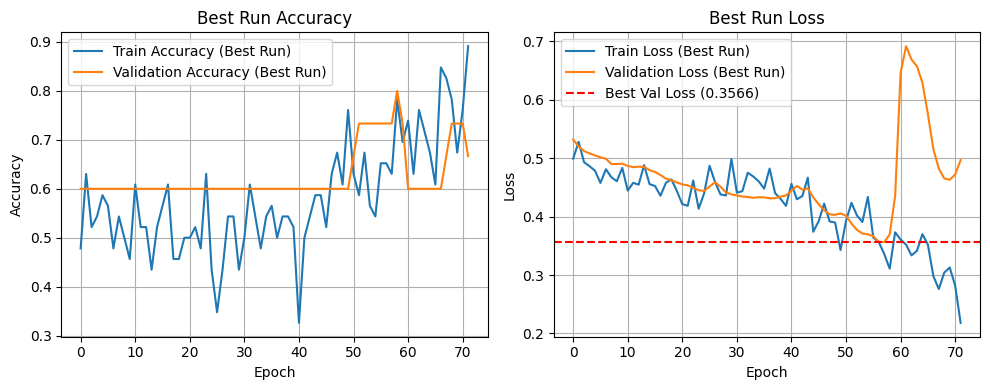

In [128]:
if best_params and best_model_state:
    best_run_history = None
    for res in results:
        if res['params'] == best_params:
            best_run_history = res['history']
            break

    if best_run_history:
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.plot(best_run_history['train_acc'], label='Train Accuracy (Best Run)')
        plt.plot(best_run_history['val_acc'], label='Validation Accuracy (Best Run)')
        plt.title('Best Run Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)

        plt.subplot(1, 2, 2)
        plt.plot(best_run_history['train_loss'], label='Train Loss (Best Run)')
        plt.plot(best_run_history['val_loss'], label='Validation Loss (Best Run)')
        plt.axhline(best_val_loss, color='r', linestyle='--', label=f'Best Val Loss ({best_val_loss:.4f})')
        plt.title('Best Run Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.savefig('../data/images/best_run_metrics.png')
        plt.tight_layout()
        plt.show()

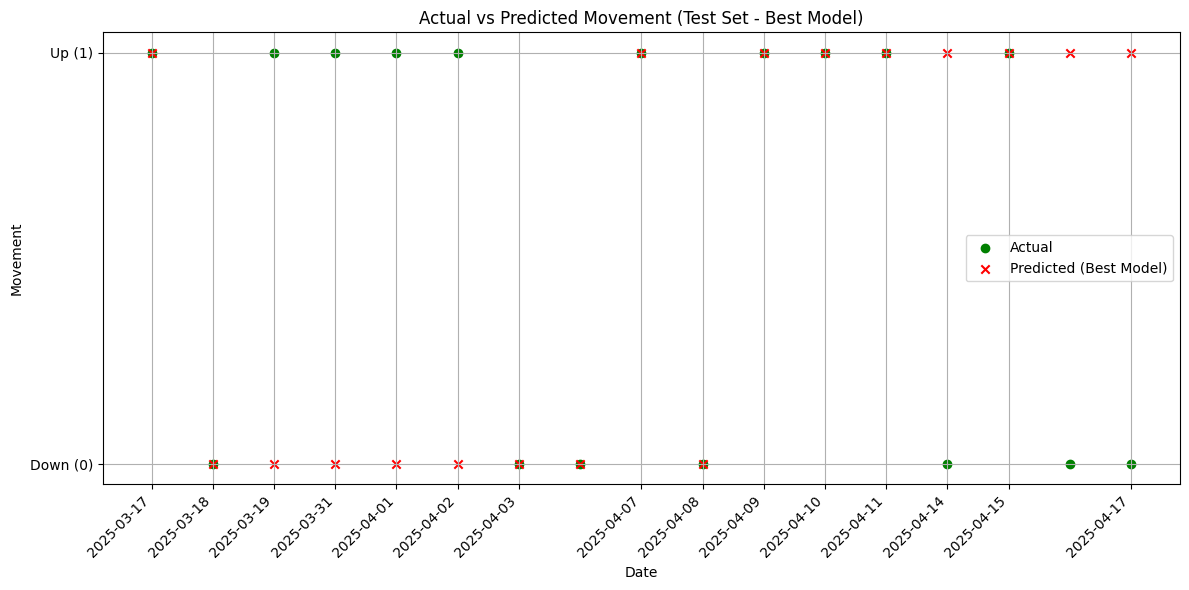

In [129]:
if best_params and best_model_state and has_date_col:
    first_test_label_idx_in_df = seq_length + train_seq_count + val_seq_count
    test_dates = df['date_only_stock'].iloc[first_test_label_idx_in_df:].reset_index(drop=True)

    if len(test_dates) == len(y_test):
        x = np.arange(len(y_test))
        plt.figure(figsize=(12,6))
        plt.scatter(x, y_test, marker='o', color='green', label='Actual')
        plt.scatter(x, test_pred_labels, marker='x', color='red', label='Predicted (Best Model)')
        date_indices_to_show = np.linspace(0, len(test_dates) - 1, min(len(test_dates), 15), dtype=int)
        plt.xticks(date_indices_to_show, test_dates.iloc[date_indices_to_show], rotation=45, ha='right')
        plt.yticks([0, 1], ['Down (0)', 'Up (1)'])
        plt.xlabel('Date')
        plt.ylabel('Movement')
        plt.title('Actual vs Predicted Movement (Test Set - Best Model)')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig('../data/images/test_set_predictions.png')
        plt.show()
    else:
        print("Warning: Length mismatch between test dates and test labels. Skipping date plot.")
else:
    print("Skipping date plot as 'date_only_stock' column not found or no best model available.")

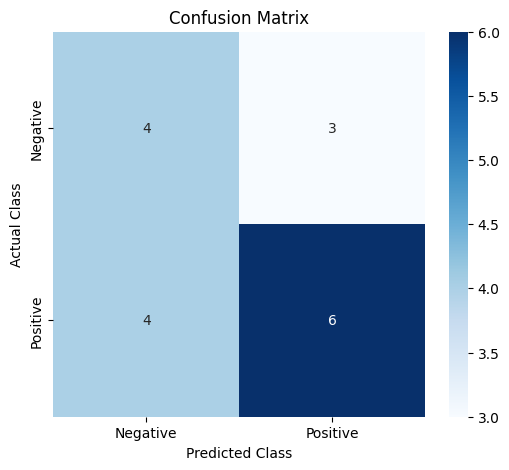

/var/folders/yx/r372mq11725b3qtfgx955zlr0000gn/T/ipykernel_40023/1755938102.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Metric', y='Score', data=metrics_df, palette='viridis')


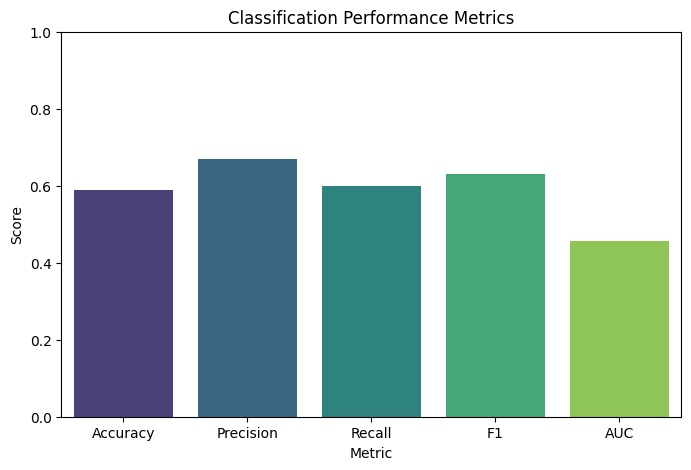

In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Confusion Matrix Data
confusion_matrix_data = np.array([[4, 3], [4, 6]])
classes = ['Negative', 'Positive']

# Create Confusion Matrix Heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix_data, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.title('Confusion Matrix')
plt.savefig('../data/images/aapl_LST_CM.png')
plt.show()


# Classification Metrics Data
metrics_data = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1', 'AUC'],
    'Score': [0.5882, 0.67, 0.60, 0.63, 0.4571]
}
metrics_df = pd.DataFrame(metrics_data)

# Create Classification Metrics Bar Chart
plt.figure(figsize=(8, 5))
sns.barplot(x='Metric', y='Score', data=metrics_df, palette='viridis')
plt.ylabel('Score')
plt.title('Classification Performance Metrics')
plt.ylim(0, 1) # Set y-axis limit for better comparison of scores
plt.savefig('../data/images/aapl_LST_Class_Metrics.png')
plt.show()
